In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime
import math
from datetime import timedelta


In [12]:
train=pd.read_csv('../Data/train_clean_shu_lonlat_CS_0518.csv')
test = pd.read_csv('../Data/test_clean_shu_lonlat_CS_0518.csv')
macro = pd.read_csv('../Data/macro.csv')
# latlon = pd.read_csv('./data/external/sub_area_lon_lat.csv')
feature_importance = pd.read_csv('../Data/feature_importance.csv')

print ('train shape',train.shape)
print ('test shape',test.shape)
print ('macro shape',macro.shape)
print ('feature_importance shape', feature_importance.shape)

('train shape', (30471, 302))
('test shape', (7662, 299))
('macro shape', (2484, 100))
('feature_importance shape', (276, 3))


In [13]:
train.loc[train['full_sq'].isnull(),'full_sq']=train['full_sq'].median()
test.loc[test['full_sq'].isnull(),'full_sq']=test['full_sq'].median()
train['price_full_sq']=train['price_doc']/train['full_sq']
train['price_full_sq']=train['price_full_sq'].astype('int64')

train['timestamp'] = pd.to_datetime(train['timestamp'])
macro['timestamp'] = pd.to_datetime(macro['timestamp'])


In [14]:
#additional features
macro['oil_rub']   = macro['usdrub']*macro['oil_urals']
macro['brent_rub'] = macro['usdrub']*macro['brent']

usdrub


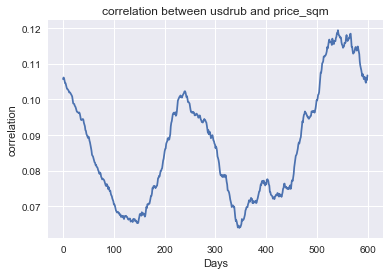

The best time lapse for usdrub is 541 days
The largest correlation is 0.12
-----------------------------------------------------------------
eurrub


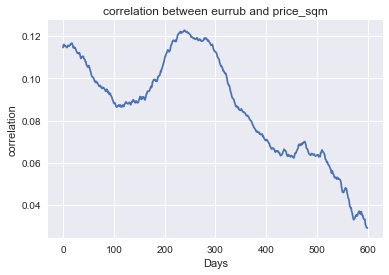

The best time lapse for eurrub is 239 days
The largest correlation is 0.12
-----------------------------------------------------------------
balance_trade


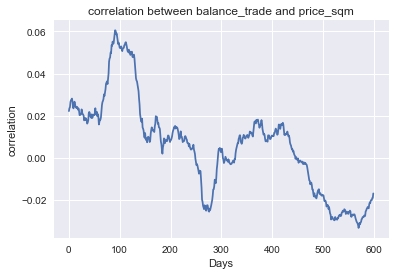

The best time lapse for balance_trade is 91 days
The largest correlation is 0.06
-----------------------------------------------------------------
balance_trade_growth


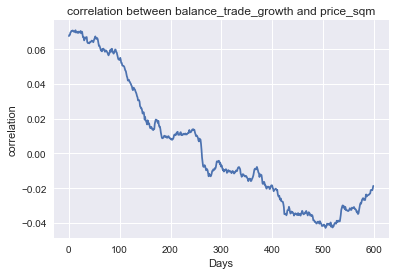

The best time lapse for balance_trade_growth is 13 days
The largest correlation is 0.07
-----------------------------------------------------------------
micex_rgbi_tr


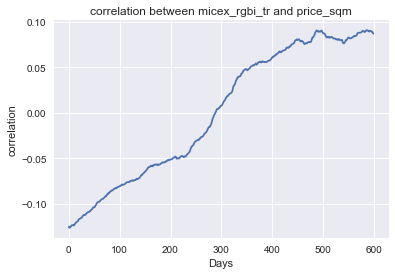

micex_cbi_tr


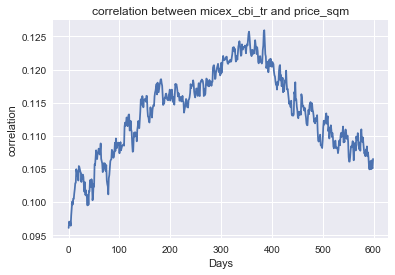

The best time lapse for micex_cbi_tr is 385 days
The largest correlation is 0.13
-----------------------------------------------------------------
deposits_rate


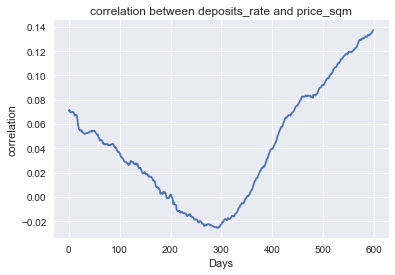

The best time lapse for deposits_rate is 599 days
The largest correlation is 0.14
-----------------------------------------------------------------
mortgage_value


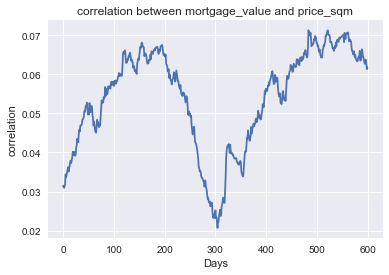

The best time lapse for mortgage_value is 521 days
The largest correlation is 0.07
-----------------------------------------------------------------
mortgage_rate


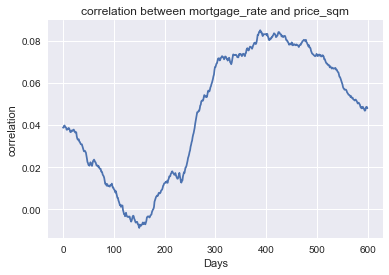

The best time lapse for mortgage_rate is 388 days
The largest correlation is 0.08
-----------------------------------------------------------------
income_per_cap


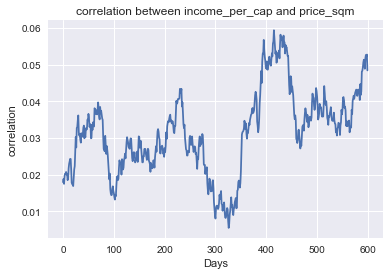

The best time lapse for income_per_cap is 415 days
The largest correlation is 0.06
-----------------------------------------------------------------
rent_price_4+room_bus


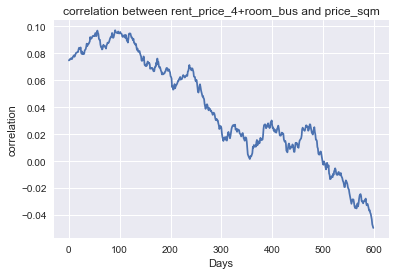

The best time lapse for rent_price_4+room_bus is 91 days
The largest correlation is 0.10
-----------------------------------------------------------------
apartment_build


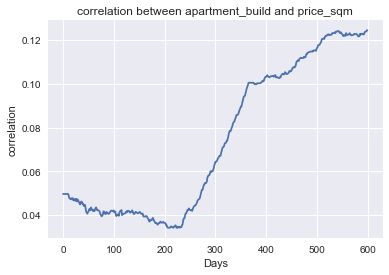

The best time lapse for apartment_build is 598 days
The largest correlation is 0.12
-----------------------------------------------------------------
brent


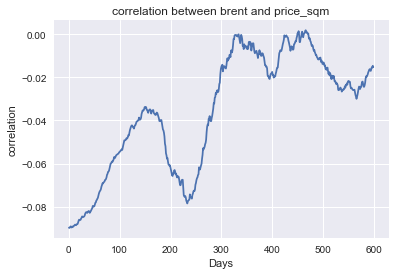

micex


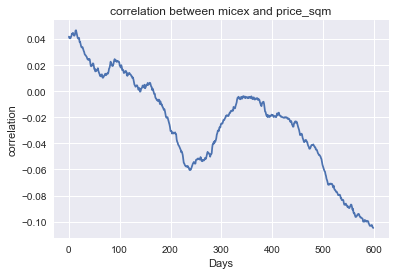

oil_urals


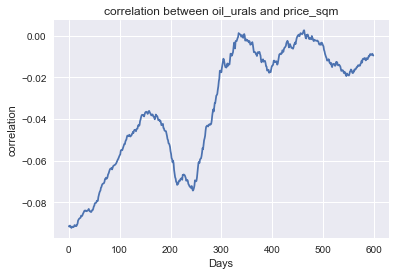

cpi


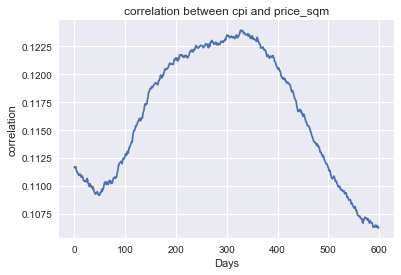

The best time lapse for cpi is 330 days
The largest correlation is 0.12
-----------------------------------------------------------------
ppi


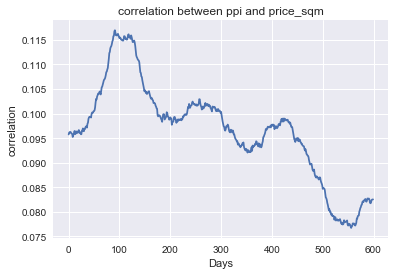

The best time lapse for ppi is 91 days
The largest correlation is 0.12
-----------------------------------------------------------------
gdp_quart


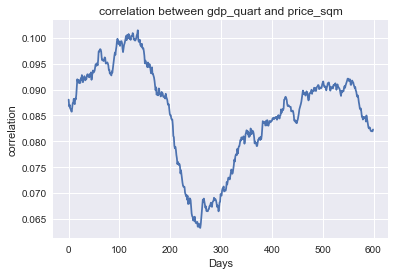

The best time lapse for gdp_quart is 136 days
The largest correlation is 0.10
-----------------------------------------------------------------
deposits_value


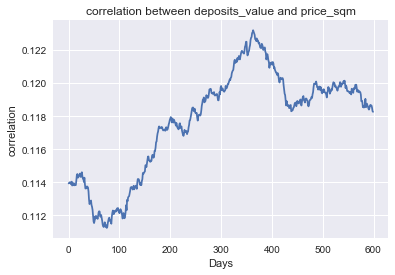

The best time lapse for deposits_value is 363 days
The largest correlation is 0.12
-----------------------------------------------------------------
mortgage_growth


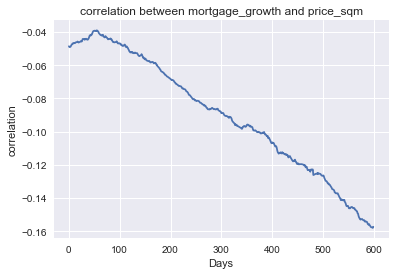

oil_rub


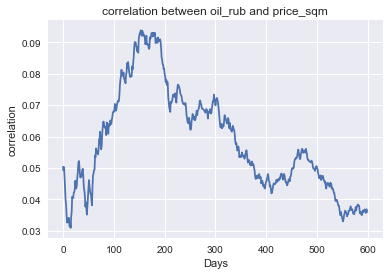

The best time lapse for oil_rub is 153 days
The largest correlation is 0.09
-----------------------------------------------------------------
brent_rub


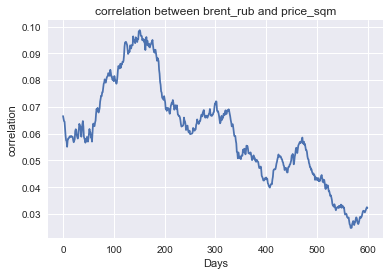

The best time lapse for brent_rub is 151 days
The largest correlation is 0.10
-----------------------------------------------------------------


In [22]:
corr_dict = {}
macro_timeshift= macro.copy()
macro_col_names = ['usdrub','eurrub',"balance_trade",'balance_trade_growth',
                   "micex_rgbi_tr","micex_cbi_tr",'deposits_rate',
                   'mortgage_value','mortgage_rate','income_per_cap',
                   'rent_price_4+room_bus','apartment_build','brent',
                   'micex','oil_urals','cpi','ppi','gdp_quart','deposits_value',
                   'mortgage_growth']

macro_col_names = macro_col_names + ['oil_rub','brent_rub']

for col_name in macro_col_names:
    print(col_name)
    for i in range(0,600):
        macro_timeshift['timestamp']=macro.timestamp+timedelta(days=i)
        price_x = pd.merge(train[['price_full_sq','timestamp']],macro_timeshift[['timestamp',col_name]],on='timestamp',how='left')
        price_x=price_x.drop(['timestamp'],axis=1)
#     #     print(price_rubusd)
        corr=price_x.corr().iloc[0,1]
        corr_dict[i] = corr
    corr_trend=pd.DataFrame(corr_dict.items(),columns=['Days','Correlation'])
#     corr_trend[['Correlation']].plot()
    fig= plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(corr_trend['Days'],corr_trend['Correlation'])
    ax.set(xlabel = 'Days',
           ylabel = 'correlation',
           title = 'correlation between {} and price_sqm'.format(col_name))
    plt.show()
    try:
        day = int(corr_trend.loc[corr_trend.Correlation==np.max(corr_trend.iloc[:,1].apply(abs)),'Days'])
        max_corr=np.max(corr_trend.iloc[:,1].apply(abs))
        print ('The best time lapse for {} is {} days'.format(col_name,day))
        print ('The largest correlation is %.2f'%max_corr)
        print ('-----------------------------------------------------------------')
    except:
        pass